### 安装yfinance

In [5]:
!pip install yfinance

# 导入python包

In [6]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import  functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

import yfinance as yf
import datetime
import time
import requests
import pandas as pd
import io
%matplotlib inline
#rom matplotlib.pylab import rcParams
from sklearn import preprocessing

# For reading stock data from Yahoo Finance
from pandas_datareader.data import DataReader

# Stock data preparation

In [7]:
ticker = 'MSFT'
start_date = datetime.datetime(2013,11,3)
end_date = datetime.datetime(2020,12,31)

#Download stock price
stock = yf.download(ticker, start= start_date, end= end_date)#, progress= False)
stock_df = stock.copy()

[*********************100%%**********************]  1 of 1 completed


In [8]:
stock_df = stock_df.reset_index()
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-04,35.590000,35.980000,35.549999,35.939999,30.035719,28060700
1,2013-11-05,35.790001,36.709999,35.770000,36.639999,30.620724,51681900
2,2013-11-06,37.240002,38.220001,37.060001,38.180000,31.907742,88948800
3,2013-11-07,37.959999,38.009998,37.430000,37.500000,31.339451,60437400
4,2013-11-08,37.669998,37.779999,37.340000,37.779999,31.573442,36737800


# 数据分析和可视化

In [9]:
stock_df.shape

(1802, 7)

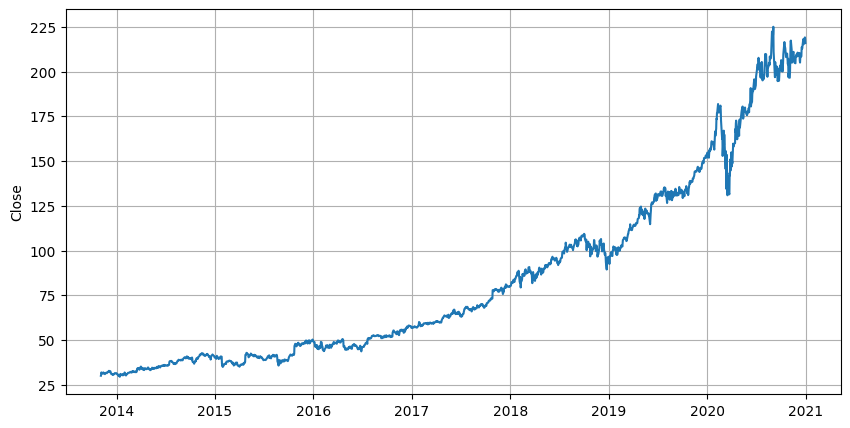

In [10]:
plt.figure(figsize = (10,5))
plt.plot(stock_df['Date'], stock_df['Adj Close'])
plt.grid()
plt.ylabel("Close")
plt.show()

In [11]:
df = stock_df.copy()
df['Price_Diff'] = df['Adj Close'].diff()
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Price_Diff
1,2013-11-05,35.790001,36.709999,35.770000,36.639999,30.620724,51681900,0.585005
2,2013-11-06,37.240002,38.220001,37.060001,38.180000,31.907742,88948800,1.287018
3,2013-11-07,37.959999,38.009998,37.430000,37.500000,31.339451,60437400,-0.568291
4,2013-11-08,37.669998,37.779999,37.340000,37.779999,31.573442,36737800,0.233992
5,2013-11-11,37.689999,37.779999,37.349998,37.590000,31.414650,26872500,-0.158792


## 数据总览

In [12]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,Price_Diff
count,1801.000000,1801.000000,1801.000000,1801.000000,1801.000000,1.801000e+03,1801.000000
mean,90.340694,91.203498,89.434070,90.369217,84.626324,3.114907e+07,0.103191
std,52.023874,52.655609,51.351728,52.032301,51.972806,1.527431e+07,1.983246
min,34.730000,35.880001,34.630001,34.980000,29.455133,7.425600e+06,-22.620361
25%,47.560001,47.930000,47.220001,47.590000,41.508179,2.178690e+07,-0.365921
50%,69.330002,69.839996,68.790001,69.459999,64.170715,2.749650e+07,0.054413
75%,117.139999,118.010002,116.129997,117.050003,111.625038,3.545870e+07,0.636246
max,229.270004,232.860001,227.350006,231.649994,225.002441,2.025224e+08,19.103149


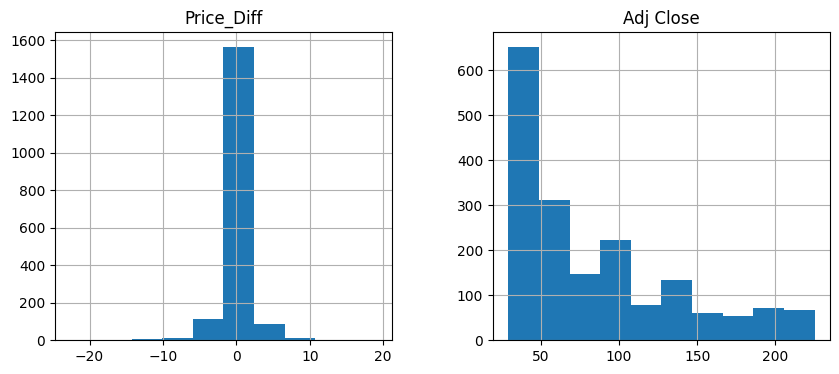

In [13]:
df[['Price_Diff', 'Adj Close']].hist(figsize = (10,4))
plt.show()

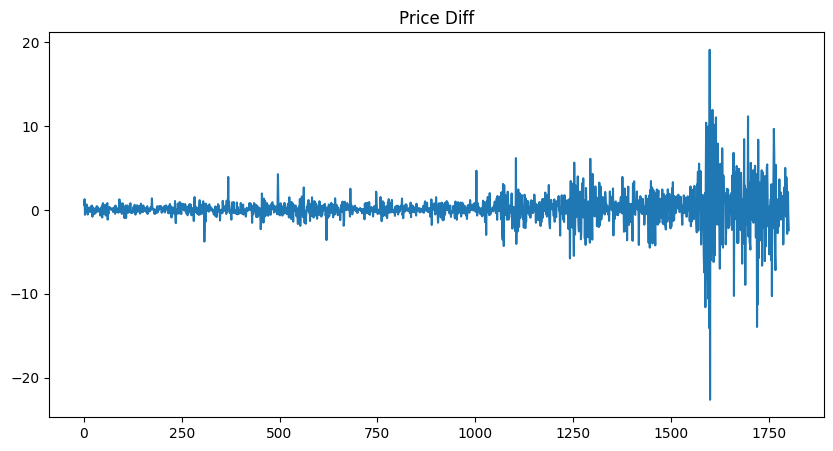

In [14]:
df['Price_Diff'].plot(figsize = (10,5))
plt.title("Price Diff")
plt.show()

## 相关性系数查看 pearson

In [15]:
df_corr = df.corr(method='pearson')
df_corr

<ipython-input-15-783b2cb505e5>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df.corr(method='pearson')


,Open,High,Low,Close,Adj Close,Volume,Price_Diff
Open,1.000000,0.999799,0.999775,0.999582,0.999567,-0.015566,0.035249
High,0.999799,1.000000,0.999643,0.999749,0.999738,-0.008233,0.042982
Low,0.999775,0.999643,1.000000,0.999785,0.999759,-0.023974,0.046510
Close,0.999582,0.999749,0.999785,1.000000,0.999971,-0.017034,0.058338
Adj Close,0.999567,0.999738,0.999759,0.999971,1.000000,-0.017388,0.057528
Volume,-0.015566,-0.008233,-0.023974,-0.017034,-0.017388,1.000000,-0.062965
Price_Diff,0.035249,0.042982,0.046510,0.058338,0.057528,-0.062965,1.000000


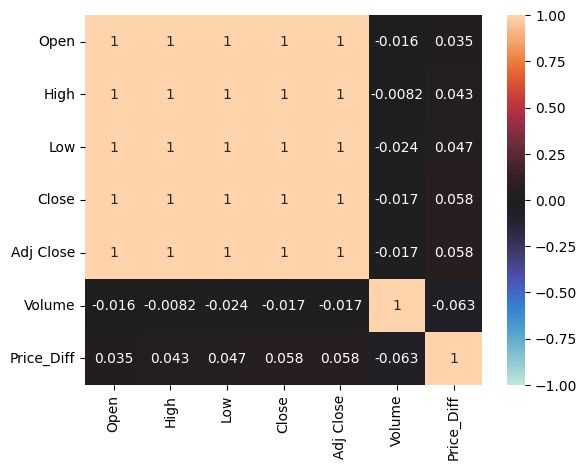

In [16]:
sns.heatmap(df_corr, vmax=1, vmin=-1, center=0, annot=True)
plt.savefig('./seaborn_heatmap_corr_example.png')

## ACF图

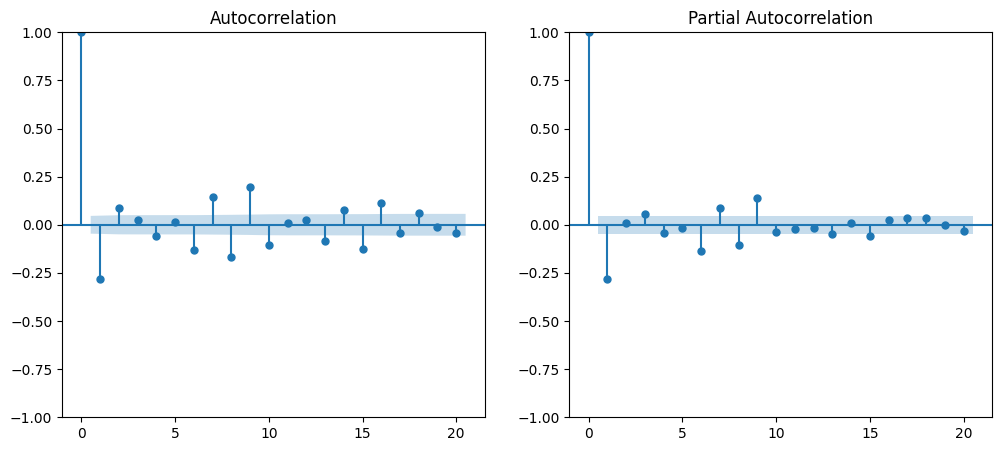

In [17]:
lags = 20
acf_values = acf(df['Price_Diff'], nlags=lags)
pacf_values = pacf(df['Price_Diff'], nlags=lags)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(df['Price_Diff'], lags=lags, ax=ax1)
plot_pacf(df['Price_Diff'], lags=lags, ax=ax2)
plt.show()


## Q-Q图

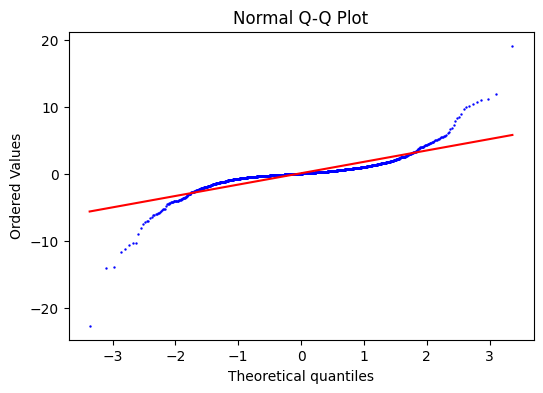

Kurtosis: 24.080730917235485


In [18]:
data = df['Price_Diff']
plt.figure(figsize=(6, 4))
qq = stats.probplot(data, dist="norm")
plt.scatter(qq[0][0], qq[0][1], s=0.5, c='blue')  # 修改点的大小
plt.plot(qq[0][0], qq[1][0] * qq[0][0] + qq[1][1], color='r')  # 绘制拟合线
plt.title('Normal Q-Q Plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')
plt.show()

kurtosis = data.kurtosis()
print(f"Kurtosis: {kurtosis}")

# Device & Function

## 确定GPU cpu使用情况

In [19]:
TRAIN_SPLIT = 1700
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## 准备训练和测试循环

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (img_rgb, y) in dataloader:
            img_rgb = img_rgb.to(device)

            y = y.to(device)

            pred = model(img_rgb)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    print(f"Test Error: \n  Avg loss: {test_loss:>8f} \n")
    return test_loss

## 可视化函数

In [21]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [22]:
def plot_one_model_predict(model, title,y_std,y_mean):
  time = 0
  model.eval()
  with torch.no_grad():
    for x, y in test_dl:
      history_x = x[0][:,1].numpy()*y_std+y_mean
      history_y = y[0].numpy()*y_std+y_mean
      predict_y = model(x)[0].numpy()*y_std+y_mean
      plot = show_plot([history_x, history_y, predict_y], 1, f'Simple {title} model')
      plot.show()
      time += 1
      if time == 5:
        break

In [23]:
def get_predict_value(model,data,predict_num = 10,is_nor = True):
  model.eval()
  with torch.no_grad():
    if is_nor:
      x_predict = data[:predict_num][0]
      y_label = data[:predict_num][1]*y_std+y_mean
      y_predict = model(x_predict).numpy()*y_std+y_mean
    else:
      x_predict = data[:predict_num][0]
      y_label = data[:predict_num][1]
      y_predict = model(x_predict).numpy()

  return y_predict,y_label

In [24]:
def plot_predict_diff(y_label,y_predict, title):

  epochs = range(len(y_label))

  plt.figure()

  plt.plot(epochs, y_label, 'b', label='y_label')
  # for y_predict in y_predict_list:
  plt.plot(epochs, y_predict, 'r', label=title)
  plt.title(title)
  plt.legend()

  plt.show()

In [25]:
def create_time_steps(length):
  return list(range(-length, 0))

In [26]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

# Preprocessing

## 选择数据

In [27]:
features_considered = ['Open','Price_Diff', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
fea_dim = len(features_considered)

features = df[features_considered]
features.index = df['Date']
features.head()

,Open,Price_Diff,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2013-11-05,35.790001,0.585005,36.709999,35.770000,36.639999,30.620724,51681900
2013-11-06,37.240002,1.287018,38.220001,37.060001,38.180000,31.907742,88948800
2013-11-07,37.959999,-0.568291,38.009998,37.430000,37.500000,31.339451,60437400
2013-11-08,37.669998,0.233992,37.779999,37.340000,37.779999,31.573442,36737800
2013-11-11,37.689999,-0.158792,37.779999,37.349998,37.590000,31.414650,26872500


## 数据可视化

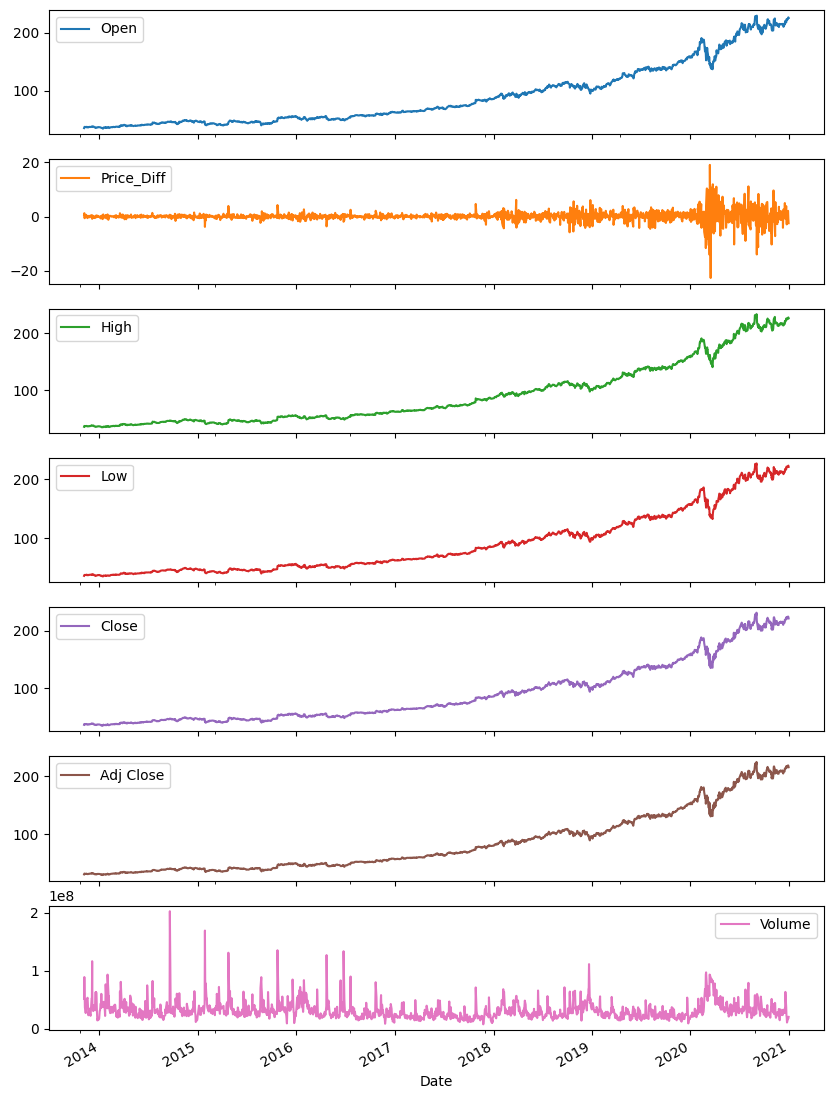

In [28]:
features.plot(subplots=True, figsize = (10,15))
plt.show()

## 数据集标准化处理

In [29]:
# Standardize the data
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

y_mean = data_mean[1]
y_std = data_std[1]
y_mean,y_std

(0.10564649806303136, 1.8058363515969797)

## 准备训练集和验证集

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [31]:
past_history = 30
future_target = 0
STEP = 1

x_train_mul, y_train_mul = multivariate_data(dataset, dataset[:, 1], 0,
                          TRAIN_SPLIT, past_history,
                          future_target, STEP,
                          single_step=True)
x_val_mul, y_val_mul = multivariate_data(dataset, dataset[:, 1],
                        TRAIN_SPLIT, None, past_history,
                        future_target, STEP,
                        single_step=True)

print ('Single window of past history : {}'.format(x_train_mul[0].shape))

Single window of past history : (30, 7)


## 查看特征和label关系并可视化

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

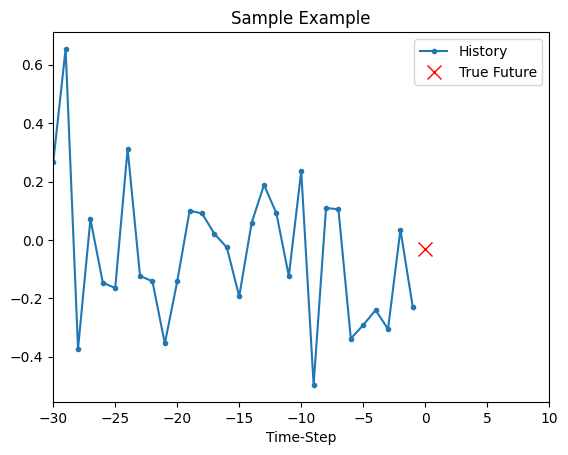

In [32]:
show_plot([x_train_mul[0][:,1], y_train_mul[0]], future_target, 'Sample Example')

In [33]:
ds_train = TensorDataset(torch.tensor(x_train_mul).float(),torch.tensor(y_train_mul).float().unsqueeze(1))
ds_test = TensorDataset(torch.tensor(x_val_mul).float(),torch.tensor(y_val_mul).float().unsqueeze(1))

batch_size = 32
train_dl = DataLoader(ds_train, batch_size=batch_size, shuffle=True,drop_last=True)
test_dl = DataLoader(ds_test, batch_size=batch_size, shuffle=False,drop_last=True)

for b_x, b_y in test_dl:
  print(b_x.shape)
  print(b_y.shape)
  break

torch.Size([32, 30, 7])
torch.Size([32, 1])


# Model

## Baseline - MA

In [ ]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

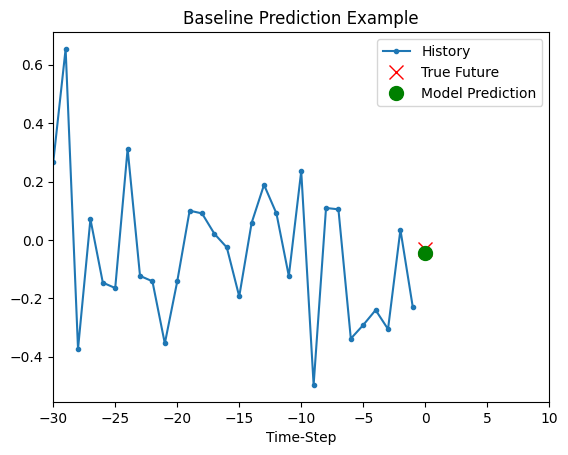

In [ ]:
show_plot([x_train_mul[0][:,1], y_train_mul[0], baseline(x_train_mul[0][:,1])], future_target,
           'Baseline Prediction Example')

## LSTM

### 构建模型

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.lstm = nn.LSTM(7,8)
        self.out = nn.Linear(240, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):

        x,_ = self.lstm(x)
        x = self.flatten(x)
        x = self.out(x)

        return x

### 准备损失函数和优化器

In [ ]:
lstm_model = LSTMModel().to(device)
loss_fn = nn.SmoothL1Loss()

score_data = []
for opt, opt_name in zip([optim.Adam, optim.SGD], ['Adam', 'SGD']):
    for lr in [1e-3, 1e-4, 1e-5]:
        model = LSTMModel().to(device)
        optimizer = opt(model.parameters(), lr=lr)
        epochs = 20
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dl, model, loss_fn, optimizer)
            train_loss = test(train_dl, model, loss_fn)
            test_loss = test(test_dl, model, loss_fn)

        print("Done!")

        score_data.append([opt_name, lr, test_loss])

score_df = pd.DataFrame(score_data, columns=['Optimizer', 'Learning Rate', 'Test Loss'])


Epoch 1
-------------------------------
loss: 0.144286  [   32/ 1670]
loss: 0.295893  [  352/ 1670]
loss: 0.197651  [  672/ 1670]
loss: 0.378928  [  992/ 1670]
loss: 0.083701  [ 1312/ 1670]
loss: 0.217697  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.269138 

Test Error: 
  Avg loss: 1.070531 

Epoch 2
-------------------------------
loss: 0.208790  [   32/ 1670]
loss: 0.220173  [  352/ 1670]
loss: 0.658304  [  672/ 1670]
loss: 0.084833  [  992/ 1670]
loss: 0.177639  [ 1312/ 1670]
loss: 0.127179  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.267023 

Test Error: 
  Avg loss: 1.068880 

Epoch 3
-------------------------------
loss: 0.517966  [   32/ 1670]
loss: 0.721084  [  352/ 1670]
loss: 0.134032  [  672/ 1670]
loss: 0.336769  [  992/ 1670]
loss: 0.213434  [ 1312/ 1670]
loss: 0.172084  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.266975 

Test Error: 
  Avg loss: 1.068588 

Epoch 4
-------------------------------
loss: 0.080008  [   32/ 1670]
loss: 0.188668  [  352/ 1670]
loss: 0.174139  [  672/ 

In [ ]:
score_df

,Optimizer,Learning Rate,Test Loss
0,Adam,0.00100,1.079452
1,Adam,0.00010,1.070761
2,Adam,0.00001,1.077783
3,SGD,0.00100,1.064862
4,SGD,0.00010,1.070764
5,SGD,0.00001,1.094897


### 训练和评估

In [ ]:
epochs = 100
train_loss_list = []
test_loss_list = []

lstm_model = LSTMModel().to(device)
loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, lstm_model, loss_fn, optimizer)
    train_loss = test(train_dl, lstm_model, loss_fn)
    test_loss = test(test_dl, lstm_model, loss_fn)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
loss: 0.296740  [   32/ 1670]
loss: 0.228334  [  352/ 1670]
loss: 0.122050  [  672/ 1670]
loss: 0.606148  [  992/ 1670]
loss: 0.237036  [ 1312/ 1670]
loss: 0.502312  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.269255 

Test Error: 
  Avg loss: 1.074472 

Epoch 2
-------------------------------
loss: 0.104147  [   32/ 1670]
loss: 0.172130  [  352/ 1670]
loss: 0.489702  [  672/ 1670]
loss: 0.520364  [  992/ 1670]
loss: 0.558135  [ 1312/ 1670]
loss: 0.338197  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.269343 

Test Error: 
  Avg loss: 1.073098 

Epoch 3
-------------------------------
loss: 0.233249  [   32/ 1670]
loss: 0.499696  [  352/ 1670]
loss: 0.457573  [  672/ 1670]
loss: 0.302718  [  992/ 1670]
loss: 0.384008  [ 1312/ 1670]
loss: 0.153311  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.268367 

Test Error: 
  Avg loss: 1.071802 

Epoch 4
-------------------------------
loss: 0.185945  [   32/ 1670]
loss: 0.511700  [  352/ 1670]
loss: 0.050520  [  672/ 

### 可视化训练过程

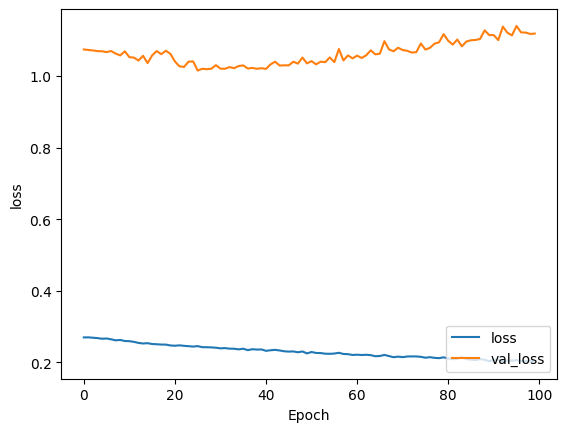

In [ ]:
loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

### 查看模型预测结果 单点预测

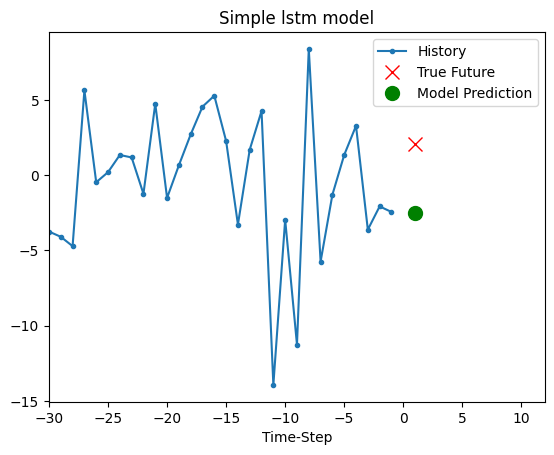

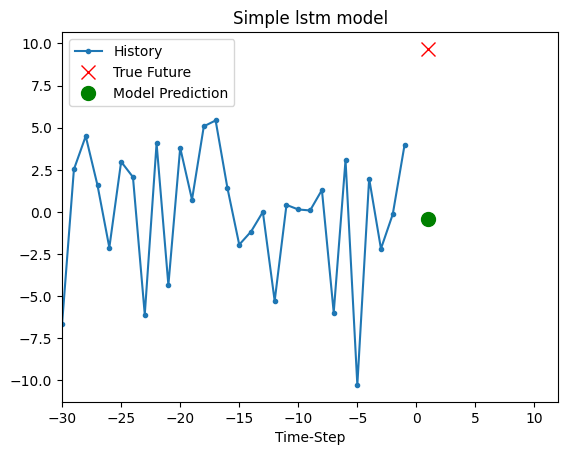

In [ ]:
def plot_one_model_predict(model, title,y_std,y_mean):
  time = 0
  model.eval()
  with torch.no_grad():
    for x, y in test_dl:
      history_x = x[0][:,1].numpy()*y_std+y_mean
      history_y = y[0].numpy()*y_std+y_mean
      predict_y = model(x)[0].numpy()*y_std+y_mean
      plot = show_plot([history_x, history_y, predict_y], 1, f'Simple {title} model')
      plot.show()
      time += 1
      if time == 5:
        break

plot_one_model_predict(lstm_model, 'lstm',y_std,y_mean)

### 查看模型预测结果 连续值预测

In [ ]:
ds_train[:10][0].shape,ds_train[:10][1].shape

(torch.Size([10, 30, 7]), torch.Size([10, 1]))

In [ ]:
y_predict, y_label = get_predict_value(lstm_model,ds_test,predict_num = 50, is_nor = True)
y_predict[:10], y_label[:10]

(array([[-2.521861  ],
        [ 0.58440304],
        [-1.0420353 ],
        [ 3.5797524 ],
        [ 2.4799538 ],
        [-2.3350592 ],
        [-0.5308914 ],
        [-1.1365016 ],
        [-0.40494943],
        [-1.7714969 ]], dtype=float32),
 tensor([[ 2.0883],
         [ 4.7400],
         [-6.6340],
         [ 2.5254],
         [ 4.4971],
         [ 1.5735],
         [-2.1175],
         [ 2.9819],
         [ 2.0688],
         [-6.0901]]))

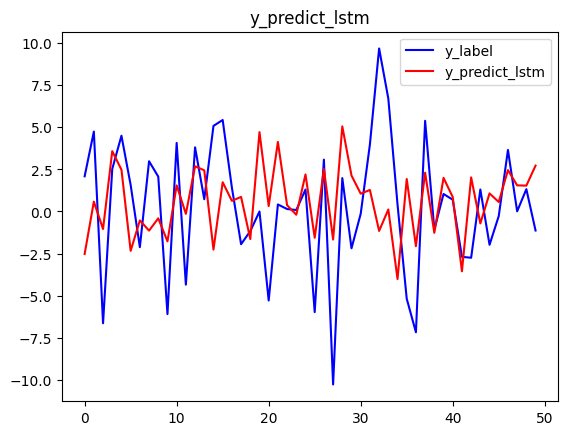

In [ ]:
plot_predict_diff(y_label,y_predict, 'y_predict_lstm')

In [ ]:
print("MAE : ", mean_absolute_error(y_label, y_predict))
print("MSE : ", mean_squared_error(y_label, y_predict))

MAE :  3.110379
MSE :  15.224754


## TCN

### 构建模型

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
# 创建虚拟的输入张量
# batch_size = 16
# sequence_length = fea_dim
# num_inputs = past_history
# dummy_input = torch.randn(batch_size, num_inputs, sequence_length)

# 创建 TemporalConvNet 模型实例
num_channels = [8, 8, 8]  # 每个 TemporalBlock 的输出通道数
kernel_size = 3
dropout = 0.2
tcn = TemporalConvNet(past_history, num_channels, kernel_size, dropout)

# 使用模型进行前向传播
output = tcn(b_x)

# 打印输出的形状
print("Output shape:", output.shape)


Output shape: torch.Size([32, 8, 7])


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
class TCNModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(past_history)
        self.tcn = tcn
        self.out = nn.Linear(56, 1)
        self.flatten = nn.Flatten()

    def forward(self, x):
        # x = self.nor(x)
        x = self.tcn(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
tcn_model = TCNModel().to(device)

tcn_model(b_x.to(device)).shape

torch.Size([32, 1])

### 准备损失函数和优化器

In [ ]:
loss_fn = nn.SmoothL1Loss()
#optimizer = torch.optim.Adam(tcn_model.parameters(), lr=1e-3)
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

# 网格搜索
score_data = []
for opt, opt_name in zip([optim.Adam, optim.SGD], ['Adam', 'SGD']):
    for lr in [1e-3, 1e-4, 1e-5]:
        # 初始化模型并移到设备
        model = TCNModel().to(device)

        # 选择优化器
        optimizer = opt(model.parameters(), lr=lr)

        # 设置训练周期
        epochs = 30
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train(train_dl, model, loss_fn, optimizer)
            train_loss = test(train_dl, model, loss_fn)
            test_loss = test(test_dl, model, loss_fn)

        print("Done!")

        # 记录模型性能
        score_data.append([opt_name, lr, test_loss])




Epoch 1
-------------------------------
loss: 0.326369  [   32/ 1670]
loss: 0.413140  [  352/ 1670]
loss: 0.372496  [  672/ 1670]
loss: 0.188924  [  992/ 1670]
loss: 0.108099  [ 1312/ 1670]
loss: 0.129791  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.265141 

Test Error: 
  Avg loss: 1.063723 

Epoch 2
-------------------------------
loss: 0.286883  [   32/ 1670]
loss: 0.191743  [  352/ 1670]
loss: 0.497748  [  672/ 1670]
loss: 0.168357  [  992/ 1670]
loss: 0.782245  [ 1312/ 1670]
loss: 0.316300  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.263015 

Test Error: 
  Avg loss: 1.058667 

Epoch 3
-------------------------------
loss: 0.405700  [   32/ 1670]
loss: 0.220752  [  352/ 1670]
loss: 0.187798  [  672/ 1670]
loss: 0.345433  [  992/ 1670]
loss: 0.304564  [ 1312/ 1670]
loss: 0.192565  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.260744 

Test Error: 
  Avg loss: 1.053755 

Epoch 4
-------------------------------
loss: 0.295860  [   32/ 1670]
loss: 0.131858  [  352/ 1670]
loss: 0.188306  [  672/ 

In [ ]:
# 创建DataFrame来展示结果
score_df = pd.DataFrame(score_data, columns=['Optimizer', 'Learning Rate', 'Test Loss'])
score_df

,Optimizer,Learning Rate,Test Loss
0,Adam,0.00100,1.139832
1,Adam,0.00010,1.127961
2,Adam,0.00001,1.067703
3,SGD,0.00100,1.115055
4,SGD,0.00010,1.059262
5,SGD,0.00001,1.039565


### 训练和评估

In [ ]:
optimizer = torch.optim.SGD(tcn_model.parameters(), lr=1e-4)
epochs = 100
train_loss_list = []

test_loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, tcn_model, loss_fn, optimizer)

    train(train_dl, tcn_model, loss_fn, optimizer)
    train_loss = test(train_dl, tcn_model, loss_fn)
    test_loss = test(test_dl, tcn_model, loss_fn)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.279799  [   32/ 1670]
loss: 0.279571  [  352/ 1670]
loss: 0.196235  [  672/ 1670]
loss: 0.209474  [  992/ 1670]
loss: 0.170646  [ 1312/ 1670]
loss: 0.255632  [ 1632/ 1670]
loss: 0.405753  [   32/ 1670]
loss: 0.305301  [  352/ 1670]
loss: 0.106628  [  672/ 1670]
loss: 0.343316  [  992/ 1670]
loss: 0.227076  [ 1312/ 1670]
loss: 0.273337  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.306162 

Test Error: 
  Avg loss: 1.291719 

Epoch 2
-------------------------------
loss: 0.312223  [   32/ 1670]
loss: 0.294322  [  352/ 1670]
loss: 0.445142  [  672/ 1670]
loss: 0.278461  [  992/ 1670]
loss: 0.791538  [ 1312/ 1670]
loss: 0.449717  [ 1632/ 1670]
loss: 0.228626  [   32/ 1670]
loss: 0.294822  [  352/ 1670]
loss: 0.332167  [  672/ 1670]
loss: 0.723216  [  992/ 1670]
loss: 0.142357  [ 1312/ 1670]
loss: 0.152115  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.299659 

Test Error: 
  Avg loss: 1.261933 

Epoch 3
-------------------------------
loss: 0.575507  

### 可视化训练过程

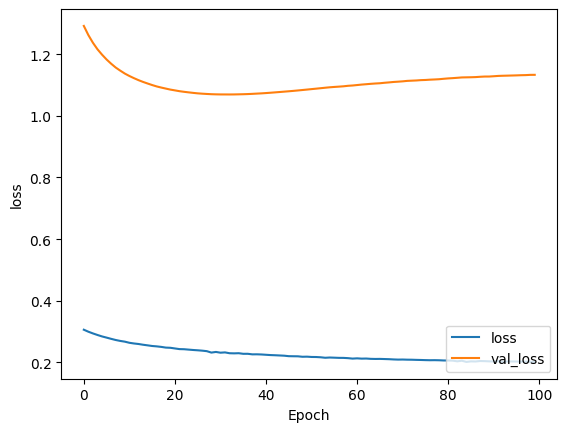

In [ ]:
loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### 查看模型预测结果 单点预测

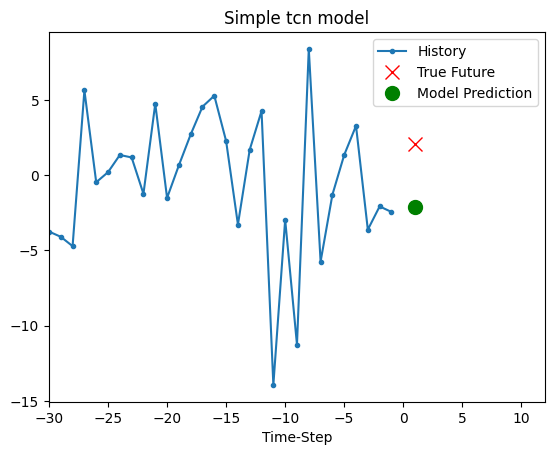

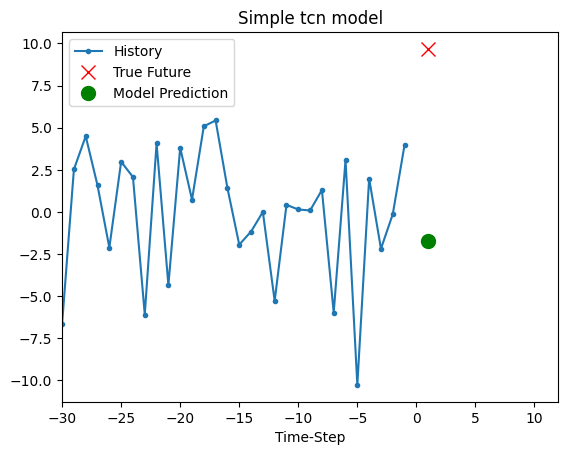

In [ ]:
plot_one_model_predict(tcn_model, 'tcn',y_std,y_mean)

### 查看模型预测结果 连续值预测

In [ ]:
y_predict, y_label = get_predict_value(tcn_model,ds_test,predict_num = 50, is_nor = False)
y_predict[:10], y_label[:10]

(array([[-1.240518  ],
        [-0.5133801 ],
        [-1.4710848 ],
        [ 1.3908005 ],
        [ 1.3204054 ],
        [-1.8675336 ],
        [ 0.62798935],
        [-0.43257132],
        [ 1.9551406 ],
        [-0.3160109 ]], dtype=float32),
 tensor([[ 1.0979],
         [ 2.5663],
         [-3.7322],
         [ 1.3400],
         [ 2.4318],
         [ 0.8129],
         [-1.2311],
         [ 1.5928],
         [ 1.0871],
         [-3.4310]]))

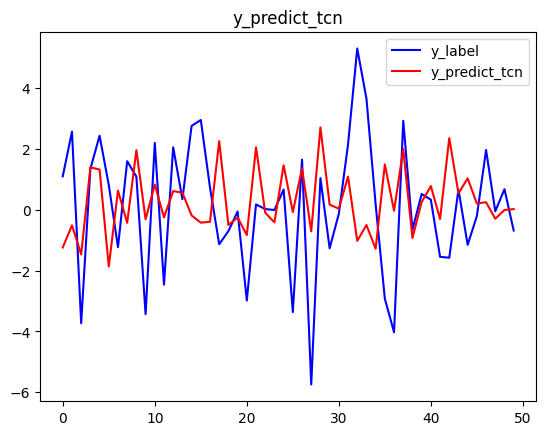

In [ ]:
plot_predict_diff(y_label,y_predict, 'y_predict_tcn')

In [ ]:
print("MAE : ", mean_absolute_error(y_label, y_predict))
print("MSE : ", mean_squared_error(y_label, y_predict))

MAE :  1.7531108
MSE :  5.2283382


## MixedModel = TCN + LSTM

### 构建模型

In [ ]:
import torch
import torch.nn as nn

# 假设LSTMModel和TCNModel类已经定义
#class LSTMModel(nn.Module):
    # LSTM模型定义
    # ...

#class TCNModel(nn.Module):
    # TCN模型定义
    # ...

class MixedModel(nn.Module):
    def __init__(self, lstm_model, tcn_model):
        super().__init__()
        self.lstm = lstm_model
        self.tcn = tcn_model
        # 可以添加更多层来结合两个模型的输出
        self.out = nn.Linear(2, 1)  # 假设每个模型输出一个特征

    def forward(self, x):
        lstm_out = self.lstm(x)
        tcn_out = self.tcn(x)
        combined = torch.cat((lstm_out, tcn_out), dim=1)
        return self.out(combined)

# 初始化子模型
lstm_model = LSTMModel().to(device)
tcn_model = TCNModel().to(device)

# 创建混合模型实例
mixed_model = MixedModel(lstm_model, tcn_model).to(device)

# 定义损失函数
loss_fn = nn.SmoothL1Loss()

# 定义子模型的优化器
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
optimizer_tcn = torch.optim.SGD(tcn_model.parameters(), lr=1e-4)




### 训练混合模型

In [ ]:
# 训练混合模型
def train_mixed(dataloader, mixed_model, loss_fn, optimizer_lstm, optimizer_tcn):
    mixed_model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 前向传播
        pred = mixed_model(X)
        loss = loss_fn(pred, y)

        # 反向传播和优化
        optimizer_lstm.zero_grad()
        optimizer_tcn.zero_grad()
        loss.backward()
        optimizer_lstm.step()
        optimizer_tcn.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

# 训练循环
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_mixed(train_dl, mixed_model, loss_fn, optimizer_lstm, optimizer_tcn)
    # 可以添加测试代码

Epoch 1
-------------------------------
loss: 0.252352  [   32/ 1670]
loss: 0.405965  [  352/ 1670]
loss: 0.342527  [  672/ 1670]
loss: 0.481128  [  992/ 1670]
loss: 0.320080  [ 1312/ 1670]
loss: 0.224319  [ 1632/ 1670]
Epoch 2
-------------------------------
loss: 0.406898  [   32/ 1670]
loss: 0.086769  [  352/ 1670]
loss: 0.196137  [  672/ 1670]
loss: 0.177174  [  992/ 1670]
loss: 0.148731  [ 1312/ 1670]
loss: 0.370580  [ 1632/ 1670]
Epoch 3
-------------------------------
loss: 0.122427  [   32/ 1670]
loss: 0.558866  [  352/ 1670]
loss: 0.230097  [  672/ 1670]
loss: 0.238912  [  992/ 1670]
loss: 0.294071  [ 1312/ 1670]
loss: 0.478896  [ 1632/ 1670]
Epoch 4
-------------------------------
loss: 0.309324  [   32/ 1670]
loss: 0.063714  [  352/ 1670]
loss: 0.215605  [  672/ 1670]
loss: 0.240391  [  992/ 1670]
loss: 0.547311  [ 1312/ 1670]
loss: 0.122950  [ 1632/ 1670]
Epoch 5
-------------------------------
loss: 0.172185  [   32/ 1670]
loss: 0.129361  [  352/ 1670]
loss: 0.243273  [  6

### 测试混合模型

In [ ]:
# 测试混合模型
def test_mixed(dataloader, mixed_model, loss_fn):
    mixed_model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = mixed_model(X)
            total_loss += loss_fn(pred, y).item()
    return total_loss / len(dataloader)

# 训练和测试循环

train_loss_list = []
test_loss_list = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_mixed(train_dl, mixed_model, loss_fn, optimizer_lstm, optimizer_tcn)
    train_loss = test_mixed(train_dl, mixed_model, loss_fn)
    test_loss = test_mixed(test_dl, mixed_model, loss_fn)
    print(f"Test loss: {test_loss:>8f}")

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)


Epoch 1
-------------------------------
loss: 0.372766  [   32/ 1670]
loss: 0.056897  [  352/ 1670]
loss: 0.332667  [  672/ 1670]
loss: 0.113707  [  992/ 1670]
loss: 0.229616  [ 1312/ 1670]
loss: 0.338958  [ 1632/ 1670]
Test loss: 1.004548
Epoch 2
-------------------------------
loss: 0.404226  [   32/ 1670]
loss: 0.139090  [  352/ 1670]
loss: 0.307258  [  672/ 1670]
loss: 0.254014  [  992/ 1670]
loss: 0.276660  [ 1312/ 1670]
loss: 0.344075  [ 1632/ 1670]
Test loss: 1.002231
Epoch 3
-------------------------------
loss: 0.266527  [   32/ 1670]
loss: 0.129454  [  352/ 1670]
loss: 0.469356  [  672/ 1670]
loss: 0.219859  [  992/ 1670]
loss: 0.434335  [ 1312/ 1670]
loss: 0.312460  [ 1632/ 1670]
Test loss: 0.999615
Epoch 4
-------------------------------
loss: 0.354012  [   32/ 1670]
loss: 0.146995  [  352/ 1670]
loss: 0.324866  [  672/ 1670]
loss: 0.140645  [  992/ 1670]
loss: 0.070542  [ 1312/ 1670]
loss: 0.284168  [ 1632/ 1670]
Test loss: 0.984732
Epoch 5
-------------------------------


### 可视化训练过程

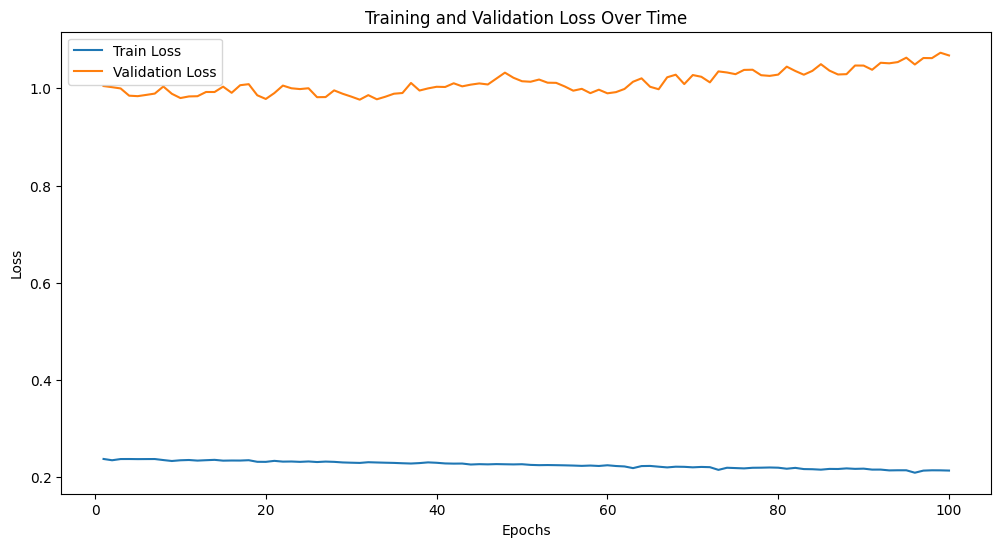

In [ ]:
# 绘制训练和验证损失曲线
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_loss_list, label='Train Loss')
plt.plot(range(1, epochs + 1), test_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


### 查看模型预测结果 单点预测

In [ ]:
def plot_one_mixed_model_predict(mixed_model, title, y_std, y_mean):
    time = 0
    mixed_model.eval()
    with torch.no_grad():
        for x, y in test_dl:
            history_x = x[0][:, 1].numpy() * y_std + y_mean
            history_y = y[0].numpy() * y_std + y_mean
            predict_y = mixed_model(x)[0].numpy() * y_std + y_mean
            plot = show_plot([history_x, history_y, predict_y], 1, f'Simple {title} model')
            plot.show()
            time += 1
            if time == 5:
                break


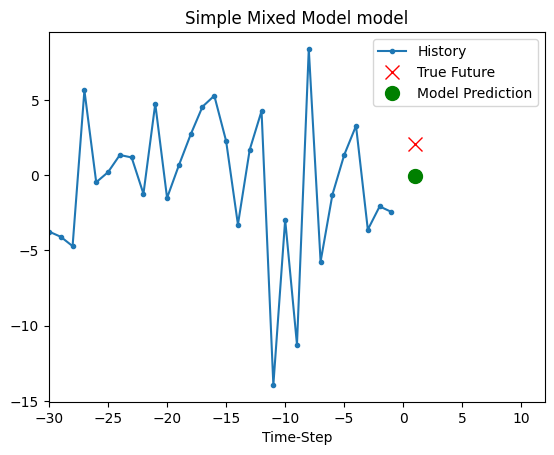

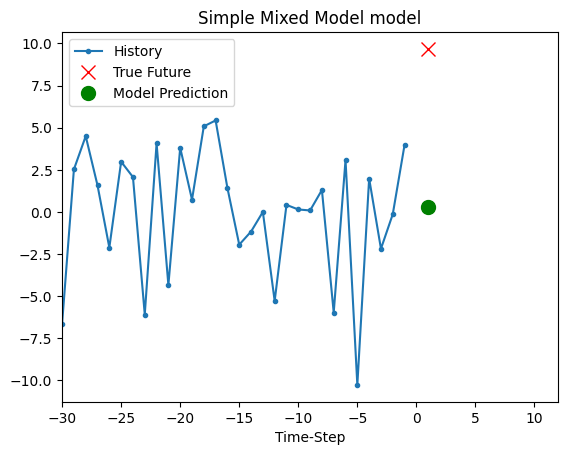

In [ ]:
plot_one_mixed_model_predict(mixed_model, 'Mixed Model', y_std, y_mean)


### 查看模型预测结果 连续值预测

In [ ]:
def get_mixed_model_continuous_predict(model, data_loader, predict_num=50):
    model.eval()
    predictions, labels = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            if i >= predict_num:
                break
            prediction = model(x.to(device))
            predictions.append(prediction.cpu().numpy())
            labels.append(y.cpu().numpy())

    return np.concatenate(predictions, axis=0), np.concatenate(labels, axis=0)

y_predict, y_label = get_mixed_model_continuous_predict(mixed_model, test_dl, 50)


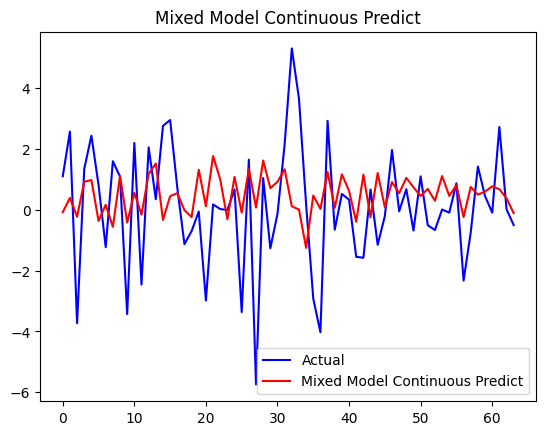

In [ ]:
def plot_continuous_predict(y_label, y_predict, title):
    epochs = range(len(y_label))
    plt.figure()
    plt.plot(epochs, y_label, 'b', label='Actual')
    plt.plot(epochs, y_predict, 'r', label=title)
    plt.title(title)
    plt.legend()
    plt.show()

plot_continuous_predict(y_label, y_predict, 'Mixed Model Continuous Predict')


### 指标分析

In [ ]:
mae = mean_absolute_error(y_label, y_predict)
mse = mean_squared_error(y_label, y_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 1.5027027130126953
Mean Squared Error: 3.764009475708008


## t2v+tcn+lstm+att

### 构造T2V层

In [35]:


class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def forward(self, x):
        batch_size, seq_len, num_features = x.size()

        x = torch.mean(x[:, :, :4], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(dim=-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(dim=-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

    def initialize_weights(self):
        self.weights_linear = nn.Parameter(torch.Tensor(self.seq_len))
        nn.init.uniform_(self.weights_linear)

        self.bias_linear = nn.Parameter(torch.Tensor(self.seq_len))
        nn.init.uniform_(self.bias_linear)

        self.weights_periodic = nn.Parameter(torch.Tensor(self.seq_len))
        nn.init.uniform_(self.weights_periodic)

        self.bias_periodic = nn.Parameter(torch.Tensor(self.seq_len))
        nn.init.uniform_(self.bias_periodic)

    def get_config(self):
        return {'seq_len': self.seq_len}


input_shape_eg = (10, 30, 6)
eg_tensor = torch.randn(input_shape_eg)

seq_len = input_shape_eg[1]  # Extract the sequence length from input shape
time_embedding = Time2Vector(seq_len)
time_embedding.initialize_weights()

output = time_embedding(eg_tensor)
print(output.shape)


torch.Size([10, 30, 2])


### 构造lstm模块

In [36]:
class LSTMBlock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.lstm = nn.LSTM(11,8)
        self.out = nn.Linear(240, 100)
        self.flatten = nn.Flatten()

    def forward(self, x):

        x,_ = self.lstm(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
lstm_block = LSTMBlock().to(device)
# text_cnn(text)[0].shape,text_cnn(text)[1].shape,text_cnn(text)[2].shape

lstm_block(b_x.to(device)).shape

torch.Size([32, 100])

### tcn模块

In [37]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm


class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [38]:
# 创建虚拟的输入张量
# batch_size = 16
# sequence_length = fea_dim
# num_inputs = past_history
# dummy_input = torch.randn(batch_size, num_inputs, sequence_length)

# 创建 TemporalConvNet 模型实例
num_channels = [8, 8, 8]  # 每个 TemporalBlock 的输出通道数
kernel_size = 3
dropout = 0.2
tcn = TemporalConvNet(past_history, num_channels, kernel_size, dropout)

# 使用模型进行前向传播
output = tcn(b_x)

# 打印输出的形状
print("Output shape:", output.shape)


Output shape: torch.Size([32, 8, 7])


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [39]:
class TCNBlock(nn.Module):
    def __init__(self,):
        super().__init__()
        self.nor = nn.BatchNorm1d(past_history)
        self.tcn = tcn
        self.out = nn.Linear(88, 100)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.nor(x)
        x = self.tcn(x)
        x = self.flatten(x)
        x = self.out(x)

        return x
tcn_block = TCNBlock().to(device)

# tcn_block(b_x.to(device)).shape

### 构建大模型

In [40]:
class BigModel(nn.Module):
    def __init__(self,):
        super().__init__()
        self.time_embedding = time_embedding
        self.lstm_block = lstm_block
        self.tcn_block = tcn_block

        self.lin1 = nn.Linear(9, 11)
        self.lin2 = nn.Linear(200, 50)
        self.lin3 = nn.Linear(60, 50)
        self.out = nn.Linear(50, 1)
        self.flatten = nn.Flatten()
        self.time_embedding = Time2Vector(seq_len)
        self.time_embedding.initialize_weights()
        self.nor = nn.BatchNorm1d(past_history)

        self.att = nn.TransformerEncoderLayer(d_model=100, nhead=5)

    def forward(self, x):
        x = self.nor(x)
        # T2V 提取特征
        x_t2v = self.time_embedding(x)
        x = torch.cat([x,x_t2v],dim=-1)
        x = self.lin1(x)

        # lstm 提取特征
        x_lstm = self.lstm_block(x)
        # tcn 提取特征
        x_tcn = self.tcn_block(x)

        x_mid = torch.stack((x_lstm,x_tcn), dim=1)
        x_mid = self.att(x_mid)
        x_mid = self.flatten(x_mid)
        # print(x_mid.shape)
        x = F.relu(self.lin2(x_mid))
        x = self.out(x)

        return x
big_model = BigModel().to(device)

big_model(b_x.to(device)).shape

torch.Size([32, 1])

### 准备损失函数和优化器

In [41]:
loss_fn = nn.SmoothL1Loss()

In [42]:
!pip install bayesian-optimization

In [43]:
from bayes_opt import BayesianOptimization
import torch
import numpy as np

# 假设您的数据加载器和模型已经正确设置
# train_dl, test_dl = ...

# 定义一个评估模型性能的函数
def evaluate_model(learning_rate, optimizer_index):
    # 根据optimizer_index选择优化器
    optimizer_index = int(optimizer_index)
    optimizer_choice = [torch.optim.Adam, torch.optim.SGD][optimizer_index]

    # 设置模型
    model = BigModel().to(device)  # 直接实例化 BigModel

    # 设置优化器
    optimizer = optimizer_choice(model.parameters(), lr=learning_rate)

    # 训练模型
    for epoch in range(5):  # 假设训练5个epoch
        train(train_dl, model, loss_fn, optimizer)
        val_loss = test(test_dl, model, loss_fn)

    # 返回验证损失作为优化目标
    return -val_loss  # 负号是因为贝叶斯优化默认是求最大值

# 设置贝叶斯优化的参数范围
pbounds = {
    'learning_rate': (1e-5, 1e-2),  # 学习率的范围
    'optimizer_index': (0, 1),      # 优化器索引，0代表Adam，1代表SGD
}

# 初始化贝叶斯优化器
optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds,
    random_state=1,
)

# 运行优化
optimizer.maximize(
    init_points=2,  # 随机探索的步数
    n_iter=10,      # 贝叶斯优化的迭代次数
)

# 输出最佳参数
print(optimizer.max)


|   iter    |  target   | learni... | optimi... |
-------------------------------------------------
loss: 0.228295  [   32/ 1670]
loss: 0.308501  [  352/ 1670]
loss: 0.295678  [  672/ 1670]
loss: 0.305317  [  992/ 1670]
loss: 0.396664  [ 1312/ 1670]
loss: 0.192892  [ 1632/ 1670]
Test Error: 
  Avg loss: 1.069643 

loss: 0.464065  [   32/ 1670]
loss: 0.664225  [  352/ 1670]
loss: 0.695437  [  672/ 1670]
loss: 0.173501  [  992/ 1670]
loss: 0.053158  [ 1312/ 1670]
loss: 0.113227  [ 1632/ 1670]
Test Error: 
  Avg loss: 1.066223 

loss: 0.193853  [   32/ 1670]
loss: 0.178834  [  352/ 1670]
loss: 0.482419  [  672/ 1670]
loss: 0.141288  [  992/ 1670]
loss: 0.179452  [ 1312/ 1670]
loss: 0.240706  [ 1632/ 1670]
Test Error: 
  Avg loss: 1.074241 

loss: 0.362434  [   32/ 1670]
loss: 0.134647  [  352/ 1670]
loss: 0.254178  [  672/ 1670]
loss: 0.242677  [  992/ 1670]
loss: 0.096709  [ 1312/ 1670]
loss: 0.194316  [ 1632/ 1670]
Test Error: 
  Avg loss: 1.075113 

loss: 0.308601  [   32/ 1670]
loss: 

In [44]:
# 获取最佳参数
best_params = optimizer.max['params']
best_learning_rate = best_params['learning_rate']
best_optimizer_index = int(round(best_params['optimizer_index']))

# 根据索引选择优化器
optimizer_choice = [torch.optim.Adam, torch.optim.SGD]
best_optimizer = optimizer_choice[best_optimizer_index]

print(f"最佳学习率: {best_learning_rate:.5f}")
print(f"最佳优化器: {'Adam' if best_optimizer_index == 0 else 'SGD'}")


最佳学习率: 0.00110
最佳优化器: Adam


### 训练和评估

In [52]:
loss_fn = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(big_model.parameters(), lr=0.00110)

In [53]:
import torch

epochs = 100
train_loss_list = []
test_loss_list = []
best_test_loss = float('inf')
best_model_weights = None

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dl, big_model, loss_fn, optimizer)
    train_loss = test(train_dl, big_model, loss_fn)
    test_loss = test(test_dl, big_model, loss_fn)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_weights = big_model.state_dict().copy()

print("Training Done!")

# Save best model weights to a file (optional)
# torch.save(best_model_weights, 'best_model_weights.pth')

# Load best model weights
big_model.load_state_dict(best_model_weights)
print("Loaded the best model weights!")


Epoch 1
-------------------------------
loss: 0.147181  [   32/ 1670]
loss: 0.634165  [  352/ 1670]
loss: 0.225631  [  672/ 1670]
loss: 0.156355  [  992/ 1670]
loss: 0.086752  [ 1312/ 1670]
loss: 0.371587  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.267714 

Test Error: 
  Avg loss: 1.065842 

Epoch 2
-------------------------------
loss: 0.131252  [   32/ 1670]
loss: 0.127403  [  352/ 1670]
loss: 0.317913  [  672/ 1670]
loss: 0.413485  [  992/ 1670]
loss: 0.105123  [ 1312/ 1670]
loss: 0.194720  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.267208 

Test Error: 
  Avg loss: 1.065329 

Epoch 3
-------------------------------
loss: 0.193856  [   32/ 1670]
loss: 0.264146  [  352/ 1670]
loss: 0.225844  [  672/ 1670]
loss: 0.099488  [  992/ 1670]
loss: 0.239248  [ 1312/ 1670]
loss: 0.150752  [ 1632/ 1670]
Test Error: 
  Avg loss: 0.268927 

Test Error: 
  Avg loss: 1.067503 

Epoch 4
-------------------------------
loss: 0.102061  [   32/ 1670]
loss: 0.362317  [  352/ 1670]
loss: 0.365015  [  672/ 

### 可视化训练过程

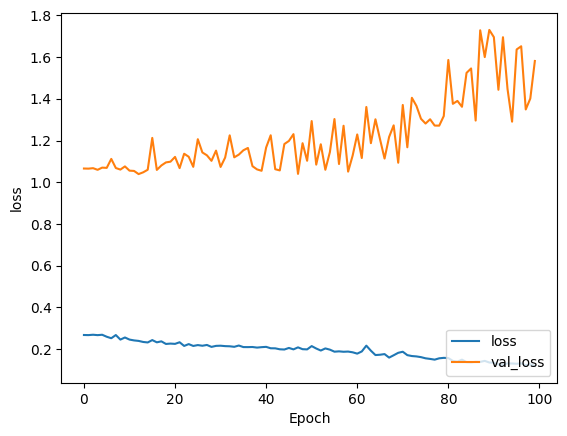

In [54]:
loss = train_loss_list
val_loss = test_loss_list
epochs_range = range(epochs)

plt.plot(loss, label='loss')
plt.plot(val_loss, label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
# plt.ylim([0.5, 1])
plt.legend(loc='lower right')

### 查看模型预测结果 单点预测

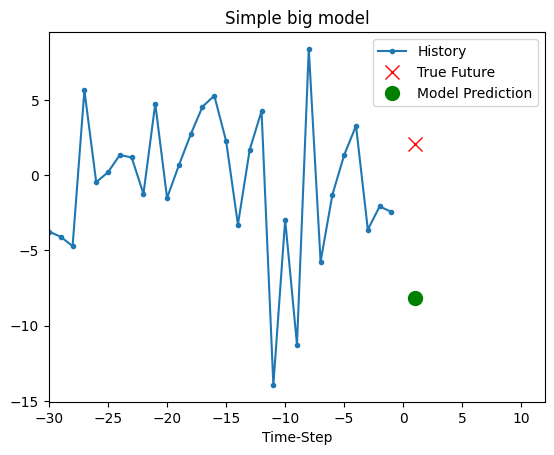

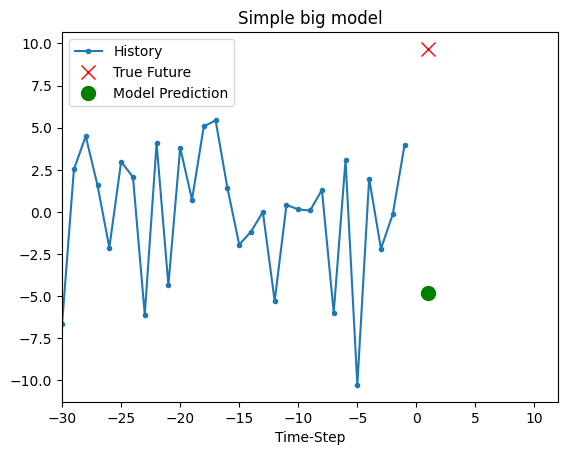

In [55]:

plot_one_model_predict(big_model, 'big',y_std,y_mean)

### 查看模型预测结果 连续值预测

In [56]:
y_predict, y_label = get_predict_value(big_model,ds_test,predict_num = 50, is_nor = False)
y_predict[:10], y_label[:10]

(array([[-4.6302404 ],
        [-2.8172543 ],
        [-2.900922  ],
        [ 1.0492578 ],
        [ 3.827125  ],
        [ 0.87502265],
        [ 0.3330923 ],
        [ 1.3264462 ],
        [ 1.664488  ],
        [ 0.5675823 ]], dtype=float32),
 tensor([[ 1.0979],
         [ 2.5663],
         [-3.7322],
         [ 1.3399],
         [ 2.4318],
         [ 0.8128],
         [-1.2311],
         [ 1.5928],
         [ 1.0872],
         [-3.4309]]))

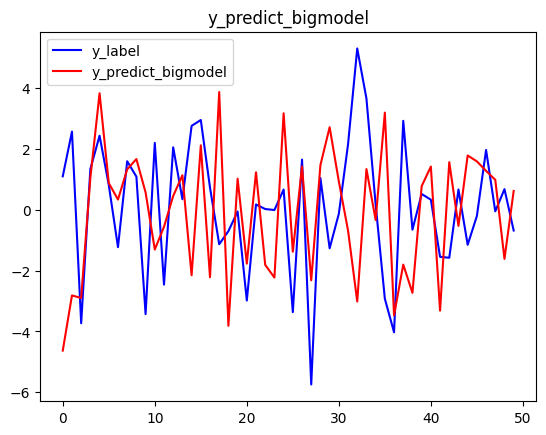

In [57]:
plot_predict_diff(y_label,y_predict, 'y_predict_bigmodel')

### 指标分析

In [51]:
mae = mean_absolute_error(y_label, y_predict)
mse = mean_squared_error(y_label, y_predict)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 1.6342697143554688
Mean Squared Error: 4.609289646148682
